In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import seaborn as sns
import string
import pickle
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/willcline/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
path = "../../data/News_Category_Dataset_v2.json"

In [3]:
df = pd.read_json(path,lines=True)

In [4]:
df.head(2)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26


In [5]:
df['all_words'] = df['headline'] + "; " + df['short_description']

In [6]:
df.drop(['link', 'date'], axis=1, inplace=True)

In [7]:
df.head(2)

,category,headline,authors,short_description,all_words
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...


### Combine similar columns and drop highly subjective ones

In [8]:
df.category = df.category.replace(["ARTS",'CULTURE & ARTS'], "ARTS & CULTURE").replace(['THE WORLDPOST'], 'WORLD NEWS').replace(['STYLE'], 'STYLE & BEAUTY')\
.replace(['TASTE'], 'FOOD & DRINK').replace(['WELLNESS'], 'HEALTHY LIVING').replace(['PARENTING'], 'PARENTS').replace(['MONEY'], 'BUSINESS')\
.replace(['COLLEGE'], 'EDUCATION').replace(['GREEN'], 'ENVIRONMENT').replace(["WOMEN", "BLACK VOICES", 'QUEER VOICES', 'LATINO VOICES'], 'DIVERSE VOICES')
df = df[~df.category.isin(['WEIRD NEWS', 'IMPACT', 'GOOD NEWS', 'FIFTY'])]

### Make Target and features DFs

### Get list of stop words

In [83]:
# generate a list of stopwords for TfidfVectorizer to ignore
stopwords_list = stopwords.words('english') + list(string.punctuation)

### Basic cleaning

In [84]:
#lower case
df['lower_desc'] = df['headline'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [85]:
#remove punctuation
df['lower_desc'] = df['lower_desc'].str.replace('[^\w\s]','')

In [86]:
#stopword gathering and removal
stop = stopwords.words('english')
df['lower_desc'] = df['lower_desc'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [87]:
X = df.drop('category', axis=1)

In [88]:
target = df.category

In [89]:
target.unique()

array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'POLITICS',
       'MINORITY VOICES', 'COMEDY', 'SPORTS', 'BUSINESS', 'TRAVEL',
       'MEDIA', 'TECH', 'RELIGION', 'SCIENCE', 'EDUCATION', 'PARENTS',
       'ARTS & CULTURE', 'STYLE & BEAUTY', 'ENVIRONMENT', 'FOOD & DRINK',
       'HEALTHY LIVING', 'HOME & LIVING', 'DIVORCE', 'WEDDINGS'],
      dtype=object)

In [90]:
len(target.unique())

23

In [91]:
#label encoder on target apparantly needed for later scoring individual sections

from sklearn.preprocessing import LabelEncoder
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(target)

In [92]:
len(set(y))

23

### Vectorize data with tf-idf(one of the 3 vectorizer methods) and make a train test split

In [93]:
#possibly unnecessary funciton to delete later on.
def preprocess_real_test(df):
    #requires stopwords list
    vectorizer = TfidfVectorizer(stop_words=stopwords_list)
    tf_idf = vectorizer.fit_transform(df)

In [94]:
# generate tf-idf vectorization (use sklearn's TfidfVectorizer) for our data
def tfidf(X, y,  stopwords_list): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    vectorizer = TfidfVectorizer(stop_words=stopwords_list)
    tf_idf_train = vectorizer.fit_transform(X_train)
    tf_idf_test = vectorizer.transform(X_test)
    return tf_idf_train, tf_idf_test, y_train, y_test, vectorizer

In [95]:
#Call above function to vectorize and train test split data and put them in variables.
#Up here because presumably only have to do it once
idf_train, idf_test, y_tr, y_t, vectorizer = tfidf(X['all_words'], y, stopwords_list)

## Fit Resample Smote on Vectorized training data

In [98]:
sm = SMOTE(random_state=42)

In [99]:
sm = SMOTE(random_state=42)
#fit resample just training data. The testing observations presumably do not require smoting
X_tr_res, y_tr_res = sm.fit_resample(idf_train, y_tr)

### Prediction function

In [101]:
def classify_text(classifier, tf_idf_train, tf_idf_test, y_train):
    classifier.fit(tf_idf_train, y_train)
    train_preds = classifier.predict(tf_idf_train)
    test_preds = classifier.predict(tf_idf_test)
    return train_preds, test_preds

### Scoring function to score predictions

In [38]:
def score_preds(y_test,y_train,test_preds, train_preds):
    print("Train: ", accuracy_score(y_train, train_preds))
    print("Test: ", accuracy_score(y_test, test_preds))
#     confusion_matrix(y_test, test_preds)
#     confusion_matrix(y_train, train_preds)

### Make baseline RF and NB models

In [102]:
rfc = RandomForestClassifier(n_estimators=100)
nb_classifier = MultinomialNB()

#### Pickle Real Test Vectorizer and Model

In [58]:
#create vectorizer object to fit to usable feature column of whole df
vectorizer = TfidfVectorizer(stop_words=stopwords_list)

In [59]:
vectorizer.fit(X['all_words'])

TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [60]:
#pickle vectorizer
with open('vectorizer.pickle', 'wb') as handle:
     pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
#open vectorizer pickle
with open('vectorizer.pickle', 'rb') as handle:
    vectorizer = pickle.load(handle)

In [62]:
#Vectorize real test usable feature column
tf_idf_app_test = vectorizer.transform(app_test['all_words'])

In [63]:
tf_idf_app_test

<1x86526 sparse matrix of type '<class 'numpy.float64'>'
	with 24 stored elements in Compressed Sparse Row format>

In [64]:
#vectorize all of X to fit best model to for real predictions
tf_idf = vectorizer.transform(X['all_words'])

In [65]:
#fit best model to vectorized form of all rows of usable feature column. This would be the model used in deployment
rfc.fit(tf_idf, y)

RandomForestClassifier()

In [66]:
#pickle best model for category picker. Comment out afterwards
with open('genre_model.pickle', 'wb') as handle:
     pickle.dump(rfc, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [67]:
#open pickled, best model
with open('genre_model.pickle', 'rb') as handle:
    rfc = pickle.load(handle)

In [69]:
#make prediction with completed model on vectorized, usable column of real test dataframe
genre = rfc.predict(tf_idf_app_test)

In [74]:
genre[0]

array(['POLITICS'], dtype=object)

### Run Baseline Models with function calls

In [103]:
len(set(y_tr_res))

23

In [104]:
#Call function using resampled, vectorized training data and vectorized test features to get a prediction on those features
nb_train_preds, nb_test_preds = classify_text(nb_classifier, X_tr_res, idf_test, y_tr_res)

In [ ]:
#Call function for score
score_preds(y_t, y_tr_res, nb_test_preds, nb_train_preds)

In [1]:
#Call function using resampled, vectorized training data and vectorized test features to get a prediction on those features
#This model performs better
rf_train_preds, rf_test_preds = classify_text(rfc, X_tr_res, idf_test, y_tr_res)

NameError: name 'classify_text' is not defined

In [ ]:
#Call function for score
score_preds(y_t, y_tr, rf_test_preds, rf_train_preds)

### Get Score of each class

In [105]:
from sklearn.metrics import precision_score

In [106]:
len(set(y_t))

23

In [9]:
target_encoder.inverse_transform(precision_score(y_t, nb_test_preds, average=None)[0])

NameError: name 'target_encoder' is not defined

In [148]:
#Make dictionary of Category name as key and relative testing score as result
each_topic_score_dict = {}
# topic_scores = precision_score(y_t, nb_test_preds, average=None)
for score, index  in zip(precision_score(y_t, nb_test_preds, average=None), range(0,len(precision_score(y_t, nb_test_preds, average=None)))):
     each_topic_score_dict[target_encoder.inverse_transform([index])[0]] = round(score,2)
#turn dict into tuple
#sort tuple
each_topic_score = [(v, k) for v, k in each_topic_score_dict.items()]
each_topic_score.sort(key=lambda x: x[1])

In [149]:
plot_labels = []
plot_scores = []
for item in list(each_topic_score):
    print(item)
    plot_labels.append(item[0])
    plot_scores.append(item[1])

('EDUCATION', 0.34)
('TECH', 0.39)
('MEDIA', 0.4)
('CRIME', 0.45)
('ENVIRONMENT', 0.47)
('RELIGION', 0.47)
('ARTS & CULTURE', 0.49)
('SCIENCE', 0.49)
('COMEDY', 0.51)
('BUSINESS', 0.53)
('DIVORCE', 0.54)
('PARENTS', 0.6)
('WEDDINGS', 0.62)
('MINORITY VOICES', 0.64)
('HOME & LIVING', 0.65)
('WORLD NEWS', 0.68)
('SPORTS', 0.7)
('ENTERTAINMENT', 0.73)
('TRAVEL', 0.74)
('FOOD & DRINK', 0.75)
('HEALTHY LIVING', 0.79)
('STYLE & BEAUTY', 0.8)
('POLITICS', 0.83)


/Users/willcline/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Topic')

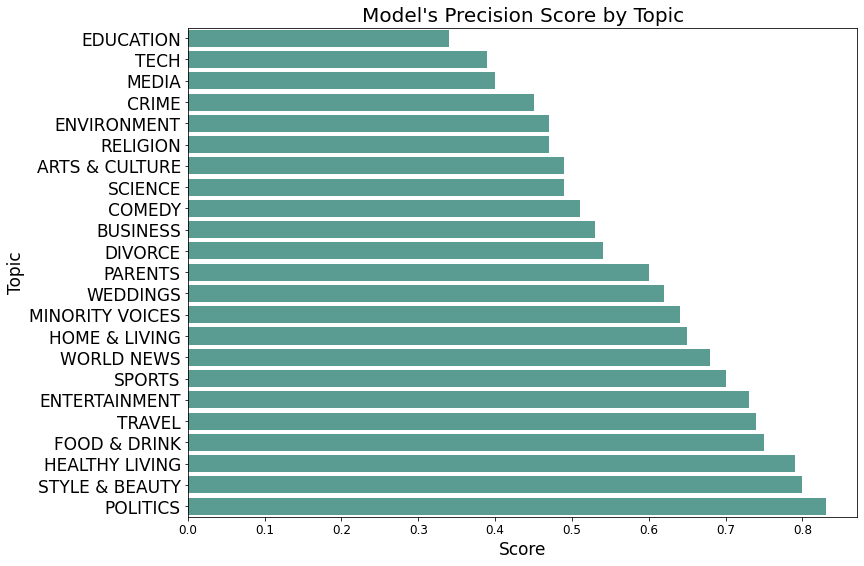

In [164]:
fig, ax = plt.subplots(figsize=(12,9))
sns.barplot(plot_scores, plot_labels, color="#4FA79A")
ax.set_title("Model's Precision Score by Topic", fontsize=20)
ax.set_xlabel("Score", fontsize=17)
ax.tick_params(axis='y', labelsize=17)
ax.tick_params(axis='x', labelsize=12)
ax.set_ylabel("Topic", fontsize=17)